In [4]:
import os
import numpy as np
import random
import csv
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from dataset import dataset
from knn import knn
#from enn import enn
#from kmeans import kmeans

In [32]:
class knn:
    def __init__(self, data: dataset, prediction_type_flag: str, k_n=1, sigma=1.0, suppress_plots=True):
        '''
        - Set a variable equal to the tune and validation sets
        - instantiate self variables
        '''
        self.suppress_plots = suppress_plots
        self.k_n = k_n
        self.sigma = sigma
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag
        self.predictions = []
        self.answers = []
        return
    def plot_loss(self, metrics: list, parameter: str, increment):
        # Extract the number of epochs and loss metrics
        metrics = np.array(metrics)
        epochs = np.arange(1, metrics.shape[0] + 1) * increment  # Assuming epochs start from 1
        loss1 = metrics[:, 0]  # First loss metric
        loss2 = metrics[:, 1]  # Second loss metric

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss1, label='Loss Metric 1', marker='o')
        plt.plot(epochs, loss2, label='Loss Metric 2', marker='o')

        # Adding labels and title
        plt.xlabel(f'{parameter} Value')
        plt.ylabel('Loss')
        plt.title(f'Loss Metrics vs. {parameter} value')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()
        plt.close()
    def tune(self, epochs=15, k_n_increment=1, sigma_increment=1):
        # CONSIDER ADDING INCREMENT PARAMETER, WHERE THE PARAMETER DECIDES HOW MUCH EACH PARAMETER
        # IS INCREMENTED PER EPOCH. SELF.K_N AND SELF.SIGMA WOULD NEED TO INITIALLY BE SET TO THE
        # INCREMENT, AND IN THE FINAL CALCULATION WHEN CHOOSING THE INDICE THE SELF.K_N/SIGMA WOULD
        # NEED TO BE MULTIPLIED BY THE INCREMENT
        '''
        SIGMA IS PRIMARILY AFFECTING THE MSE, CONSIDER ONLY USING MSE TO DETERMINE SIGMA
        '''
        '''
        Use default parameters to predict the tune set using each set of 9 partitions as the model.
        Performance should be calculated and averaged across the ENTIRE set of models with the given
        hyperparameter. A hyperparameter is incremented, and predictions is re-run. This process
        repeats until the desired number of epochs are reached.
        '''
        k_n_scores = []
        sigma_scores = []
        self.k_n = k_n_increment
        self.sigma = sigma_increment
        for i in tqdm(range(epochs), desc="Tuning K_n..."):
            self.k_n += k_n_increment
            if (self.prediction_type == 'regression'):
                k_n_scores.append(self.regress(True))
            else:
                k_n_scores.append(self.classify(True))
        if (self.suppress_plots == False):
            self.plot_loss(k_n_scores, 'K_n', k_n_increment)
            

        if (self.prediction_type == 'regression'):    
            for i in tqdm(range(epochs), desc="Tuning sigma..."):
                self.sigma += sigma_increment
                sigma_scores.append(self.regress(True))
            if (self.suppress_plots == False):
                self.plot_loss(sigma_scores, 'Sigma', sigma_increment)

        k_n_scores = np.array(k_n_scores)
        if (self.prediction_type == 'regression'):
            best_k_n_epochs = np.argmin(k_n_scores, axis=0)
        else:
            best_k_n_epochs = np.argmax(k_n_scores, axis=0)
        self.k_n = (round(np.mean(best_k_n_epochs)) + 1) * k_n_increment
        print(f"Tuned k_n: {self.k_n}")
        if (self.prediction_type == 'regression'):
            # CURRENTLY IS ONLY USING MSE TO TUNE SIGMA
            sigma_scores = np.array(sigma_scores)
            best_sigma_epochs = np.argmin(sigma_scores, axis=0)
            self.sigma = (round(np.mean(best_sigma_epochs[0] + 1))) * sigma_increment
            print(f"Tuned sigma: {self.sigma}")
        return  
    def classify(self, tuning_flag=False):
        '''
        classify holdout set repeat for each fold
        '''
        Loss_values = np.zeros((10, 2))
        predictions = []
        answers = []
        hold_out_fold = self.tune_set
        for fold_idx in tqdm(range(10), leave=False):
            if (tuning_flag == False):
                hold_out_fold = self.validate_set[fold_idx]
            model = np.concatenate([self.validate_set[i] for i in range(10) if i != fold_idx])
            #print(model.shape)
            #print(hold_out_fold.shape)

            for test_point in hold_out_fold:
                if (test_point[0] != 'null'):
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(model, test_point, self.k_n)
                    #print(f"Neighbor Indices:\n{neighbor_indices}")
                    neighbor_labels = model[neighbor_indices, -1]
                    #print(f"Neighbor Labels: {neighbor_labels}")
                    label_counts = Counter(neighbor_labels)
                    predicted_label = label_counts.most_common(1)[0][0]

                    predictions.append(float(predicted_label))
                    answers.append(true_label)

            self.predictions = np.array(predictions)
            #print(self.predictions)
            self.predictions = np.rint(self.predictions).astype(int).astype(str)
            self.answers = np.array(answers).astype(float)
            self.answers = np.rint(self.answers).astype(int).astype(str)
            #print(f"Predictions: {self.predictions}")
            #print(f"Answers: {self.answers}")
            Loss_values[fold_idx] = self.calculate_loss()
            predictions = []
            answers = []

        if tuning_flag:
            average_loss = np.mean(Loss_values, axis=0)
            return average_loss  
        else:
            print(f"Loss: {Loss_values}")
            return Loss_values 
    def regress(self, tuning_flag=False):
        '''
        regress each hold out set repeat for each fold
        '''
        Loss_values = np.zeros((10, 2))  
        predictions = []
        answers = []
        hold_out_fold = self.tune_set
        for fold_idx in tqdm(range(10), leave=False):
            if (tuning_flag == False):
                hold_out_fold = self.validate_set[fold_idx]
            model = np.concatenate([self.validate_set[i] for i in range(10) if i != fold_idx])
            #print(model.shape)
            #print(hold_out_fold.shape)

            for test_point in hold_out_fold:
                if (test_point[0] != 'null'):
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(model, test_point, self.k_n)
                    #print(f"Neighbor Indices:\n{neighbor_indices}")
                    nearest_neighbors = model[neighbor_indices]
                    #print(f"Nearest Neighbors: {nearest_neighbors}")
                    neighbor_values = nearest_neighbors[:, -1]

                    distances = np.array([np.linalg.norm(test_point[:-1].astype(float) - neighbor[:-1].astype(float)) for neighbor in nearest_neighbors])
                
                    rbf_weights = np.exp(- (distances ** 2) / (2 * self.sigma ** 2))
                    #print(f"Should be equal to last indice of the nearest neighbors: {nearest_neighbors[:, -1]}")
                    weighted_sum = np.sum(rbf_weights * nearest_neighbors[:, -1].astype(float))
                    weight_total = np.sum(rbf_weights)

                    predicted_value = weighted_sum / weight_total if weight_total != 0 else np.mean(neighbor_values.astype(float))

                    predictions.append(predicted_value)
                    answers.append(true_label)

            self.predictions = np.array(predictions)
            self.answers = np.array(answers)

            # Calculate loss for the current fold and store it
            Loss_values[fold_idx] = self.calculate_loss()

        if tuning_flag:
            average_loss = np.mean(Loss_values, axis=0)
            return average_loss  
        else:
            return Loss_values
    def calculate_loss(self):
            '''
            Classifiction: 0/1 loss, F1 score
            Regression: Mean squared error, Mean absolute

            '''
            loss = []
            if(self.prediction_type == "classification"):
                accuracy = np.mean(self.predictions == self.answers)
                loss.append(float(accuracy))

                unique_classes = np.unique(self.answers)
                f1_scores = []
                for cls in unique_classes:
                    true_positives = sum((self.predictions == cls) & (self.answers == cls))
                    predicted_positives = sum(self.predictions == cls)
                    actual_positives = sum(self.answers == cls)

                    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
                    recall = true_positives / actual_positives if actual_positives > 0 else 0

                    if precision + recall > 0:
                        f1 = 2 * (precision * recall) / (precision + recall)
                    else:
                        f1 = 0
                    f1_scores.append(f1)

                loss.append(float(np.mean(f1_scores)))

            else:
                mse = np.mean(self.answers.astype(float) - self.predictions.astype(float)) ** 2
                loss.append(float(mse))

                mae = np.mean(np.abs(self.answers.astype(float) - self.predictions.astype(float)))
                loss.append(float(mae))
            return loss
    def euclidean_distance(self, point1: np, point2: np):
        # np.linalg.norm calculates the euclidean distances between two points
        #print(f"Point 1 type: {point1.shape}")
        #print(f"Point 2 type: {point2.shape}")
        return np.linalg.norm(point1 - point2)
    def get_neighbors(self, model: np, test_point: np, k_n: int):
        '''
        - Feed this function a NxN numpy array where the first dimension is num of examples and the second dimension is num of freatures
        - The second argument is the reference point
        - the third argument is the point that is being referenced for distances
        - The method returns the class/regression value of the k_n nearest neighbors
        '''
        #print(f"Model shape: {model.shape}")
        distances = np.zeros((model.shape[0]), dtype=float)
        #print(f"Distances Shape: {distances.shape}")
        for i, model_point in enumerate(model):
            # calculate euclidean distance
            # COULD ALWAYS SWAP THIS FUNCTION CALL FOR THE ONE LINER
            if (model_point[0] != "null"):
                #print(f"test point: {test_point}")
                #print(f"model point: {model_point}")
                distances[i] = self.euclidean_distance(test_point[:-1].astype(float), model_point[:-1].astype(float))
            else:
                distances[i] = 10000000
        # np.partitions moves the K_n smallest values in an np array to the front of the array. We then slice the array to get the k_n smallest values
        smallest_distances = np.partition(distances, k_n)[:k_n]
        #print(f"Smallest distances: {smallest_distances}")
        neighbor_indices = np.where(np.isin(distances, smallest_distances))[0]
        #print(f"Neighbor Indices:\n{neighbor_indices}")
        nearest_neighbors = model[neighbor_indices]
        #print(type(nearest_neighbors))
        # CURRENTLY RETURNS THE INDICES OF THE NEAREST NEIGHBORS
        return neighbor_indices

In [33]:
class enn:
    def __init__(self, data: dataset, prediction_type_flag: str, k_n=1, sigma=1.0, epsilon=1, suppress_plots=True):
        '''
        - Set a variable equal to the tune and validation sets
        - instantiate self variables
        '''
        self.suppress_plots = suppress_plots
        self.k_n = k_n
        self.sigma = sigma
        self.epslion = epsilon
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag
        self.predictions = []
        self.answers = []
        self.reduced_models = []
        
        return
    def plot_loss(self, metrics: list, parameter: str, increment):
        # Extract the number of epochs and loss metrics
        metrics = np.array(metrics)
        epochs = np.arange(1, metrics.shape[0] + 1) * increment  # Assuming epochs start from 1
        loss1 = metrics[:, 0]  # First loss metric
        loss2 = metrics[:, 1]  # Second loss metric

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss1, label='Loss Metric 1', marker='o')
        plt.plot(epochs, loss2, label='Loss Metric 2', marker='o')

        # Adding labels and title
        plt.xlabel(f'{parameter} Value')
        plt.ylabel('Loss')
        plt.title(f'Loss Metrics vs. {parameter} value')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()
        plt.close()
    def tune(self, epochs=15, k_n_increment=1, sigma_increment=1):
        '''
        for fold_idx, fold in enumerate(self.validate_set):
            print(f"Number of examples in OG data fold {fold_idx+1}: {len(fold)}")
        for fold_idx, fold in enumerate(reduced_models):
            print(f"Number of examples in reduced data fold {fold_idx+1}: {len(fold)}")
        '''
        self.reduced_models = self.reduce_dataset(self.validate_set)
        k_n_scores = []
        sigma_scores = []
        self.k_n = k_n_increment
        self.sigma = sigma_increment
        for i in tqdm(range(epochs), desc="Tuning K_n..."):
            self.k_n += k_n_increment
            if (self.prediction_type == 'regression'):
                k_n_scores.append(self.regress(True))
            else:
                k_n_scores.append(self.classify(True))
        if (self.suppress_plots == False):
            self.plot_loss(k_n_scores, 'K_n', k_n_increment)
            

        if (self.prediction_type == 'regression'):    
            for i in tqdm(range(epochs), desc="Tuning sigma..."):
                self.sigma += sigma_increment
                sigma_scores.append(self.regress(True))
            if (self.suppress_plots == False):
                self.plot_loss(sigma_scores, 'Sigma', sigma_increment)

        k_n_scores = np.array(k_n_scores)
        if (self.prediction_type == 'regression'):
            best_k_n_epochs = np.argmin(k_n_scores, axis=0)
        else:
            best_k_n_epochs = np.argmax(k_n_scores, axis=0)
        self.k_n = (round(np.mean(best_k_n_epochs)) + 1) * k_n_increment
        print(f"Tuned k_n: {self.k_n}")
        if (self.prediction_type == 'regression'):
            # CURRENTLY IS ONLY USING MSE TO TUNE SIGMA
            sigma_scores = np.array(sigma_scores)
            best_sigma_epochs = np.argmin(sigma_scores, axis=0)
            self.sigma = (round(np.mean(best_sigma_epochs[0] + 1))) * sigma_increment
            print(f"Tuned sigma: {self.sigma}")
        return  
    def reduce_dataset(self, initial_set: np, epsilon = 0.05):
        reduced_models = []
        padded_folds = []

        for fold_idx in tqdm(range(10), desc="reducing dataset...", leave=False):
            removal_indices = []
            model = np.concatenate([initial_set[i] for i in range(10) if i != fold_idx])
            #print(f"Fold {fold_idx} Model Shape: {model.shape}")
            #print(hold_out_fold.shape)
            for test_point_idx, test_point in enumerate(model):
                if (test_point[0] != 'null'):
                    # Create a new array excluding the test point
                    self_classify_model = np.delete(model, test_point_idx, axis=0)
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(self_classify_model, test_point, self.k_n)
                    #print(f"Neighbor Indices:\n{neighbor_indices}")
                    if (self.prediction_type == "classification"):
                        neighbor_labels = self_classify_model[neighbor_indices, -1]
                        #print(f"Neighbor Labels: {neighbor_labels}")
                        label_counts = Counter(neighbor_labels)
                        predicted_label = label_counts.most_common(1)[0][0]
                        if (predicted_label != true_label):
                            removal_indices.append(test_point_idx)
                    else:
                        nearest_neighbors = self_classify_model[neighbor_indices]
                        #print(f"Nearest Neighbors: {nearest_neighbors}")
                        neighbor_values = nearest_neighbors[:, -1]
                        distances = np.array([np.linalg.norm(test_point[:-1].astype(float) - neighbor[:-1].astype(float)) for neighbor in nearest_neighbors])
                        rbf_weights = np.exp(- (distances ** 2) / (2 * self.sigma ** 2))
                        #print(f"Should be equal to last indice of the nearest neighbors: {nearest_neighbors[:, -1]}")
                        weighted_sum = np.sum(rbf_weights * nearest_neighbors[:, -1].astype(float))
                        weight_total = np.sum(rbf_weights)

                        predicted_value = weighted_sum / weight_total if weight_total != 0 else np.mean(neighbor_values.astype(float))
                        if ((abs(float(predicted_value) - float(true_label)) <= epsilon * float(predicted_value)) == False):
                            removal_indices.append(test_point_idx)
            #print(f"Fold {fold_idx+1} Shape: {np.delete(model, removal_indices, axis=0).shape}")
            reduced_models.append(np.delete(model, removal_indices, axis=0))
        
        #print(reduced_models[0])
        max_rows = max(fold.shape[0] for fold in reduced_models)
        # Pad each array to have the same number of rows (max_rows)
        for fold in reduced_models:
            pad_width = max_rows - fold.shape[0]
            padded_fold = np.pad(fold, ((0, pad_width), (0, 0)), mode='constant', constant_values='null')
            padded_folds.append(padded_fold)
        # Stack the padded arrays into a 3D array
        padded_reduced_models = np.stack(padded_folds)
        print(padded_reduced_models.shape)
        return padded_reduced_models
        #else: # regression


        #return
    def classify(self, tuning_flag=False):
        '''
        classify holdout set repeat for each fold
        '''
        Loss_values = np.zeros((10, 2))
        predictions = []
        answers = []
        hold_out_fold = self.tune_set
        for fold_idx in tqdm(range(10), leave=False):
            if (tuning_flag == False):
                hold_out_fold = self.validate_set[fold_idx]
            model = self.reduced_models[fold_idx]
            #print(model.shape)
            #print(hold_out_fold.shape)

            for test_point in hold_out_fold:
                if (test_point[0] != 'null'):
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(model, test_point, self.k_n)
                    #print(f"Neighbor Indices:\n{neighbor_indices}")
                    neighbor_labels = model[neighbor_indices, -1]
                    #print(f"Neighbor Labels: {neighbor_labels}")
                    label_counts = Counter(neighbor_labels)
                    predicted_label = label_counts.most_common(1)[0][0]

                    predictions.append(float(predicted_label))
                    answers.append(true_label)

            self.predictions = np.array(predictions)
            self.predictions = np.rint(self.predictions).astype(int).astype(str)
            self.answers = np.array(answers).astype(float)
            self.answers = np.rint(self.answers).astype(int).astype(str)
            #print(f"Predictions: {self.predictions}")
            #print(f"Answers: {self.answers}")
            Loss_values[fold_idx] = self.calculate_loss()
            predictions = []
            answers = []

        if tuning_flag:
            average_loss = np.mean(Loss_values, axis=0)
            return average_loss  
        else:
            print(f"Loss: {Loss_values}")
            return Loss_values  
    def regress(self, tuning_flag=False):
        '''
        regress each hold out set repeat for each fold
        '''
        Loss_values = np.zeros((10, 2))  
        predictions = []
        answers = []
        hold_out_fold = self.tune_set
        for fold_idx in tqdm(range(10), leave=False):
            if (tuning_flag == False):
                hold_out_fold = self.validate_set[fold_idx]
            model = self.reduced_models[fold_idx]
            #print(model.shape)
            #print(hold_out_fold.shape)

            for test_point in hold_out_fold:
                if (test_point[0] != 'null'):
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(model, test_point, self.k_n)
                    #print(f"Neighbor Indices:\n{neighbor_indices}")
                    nearest_neighbors = model[neighbor_indices]
                    nearest_neighbors = nearest_neighbors[~np.any(nearest_neighbors == 'null', axis=1)]
                    #print(f"Nearest Neighbors: {nearest_neighbors}")
                    neighbor_values = nearest_neighbors[:, -1]

                    distances = np.array([np.linalg.norm(test_point[:-1].astype(float) - neighbor[:-1].astype(float)) for neighbor in nearest_neighbors if neighbor[0] != 'null'])
                
                    rbf_weights = np.exp(- (distances ** 2) / (2 * self.sigma ** 2))
                    #print(f"Should be equal to last indice of the nearest neighbors: {nearest_neighbors[:, -1]}")
                    weighted_sum = np.sum(rbf_weights * nearest_neighbors[:, -1].astype(float))
                    weight_total = np.sum(rbf_weights)

                    predicted_value = weighted_sum / weight_total if weight_total != 0 else np.mean(neighbor_values.astype(float))

                    predictions.append(predicted_value)
                    answers.append(true_label)
                    
            self.predictions = np.array(predictions)
            self.answers = np.array(answers)

            # Calculate loss for the current fold and store it
            Loss_values[fold_idx] = self.calculate_loss()

        if tuning_flag:
            average_loss = np.mean(Loss_values, axis=0)
            return average_loss  
        else:
            return Loss_values
    def calculate_loss(self):
            '''
            Classifiction: 0/1 loss, F1 score
            Regression: Mean squared error, Mean absolute

            '''
            loss = []
            if(self.prediction_type == "classification"):
                accuracy = np.mean(self.predictions == self.answers)
                loss.append(float(accuracy))

                unique_classes = np.unique(self.answers)
                f1_scores = []
                for cls in unique_classes:
                    true_positives = sum((self.predictions == cls) & (self.answers == cls))
                    predicted_positives = sum(self.predictions == cls)
                    actual_positives = sum(self.answers == cls)

                    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
                    recall = true_positives / actual_positives if actual_positives > 0 else 0

                    if precision + recall > 0:
                        f1 = 2 * (precision * recall) / (precision + recall)
                    else:
                        f1 = 0
                    f1_scores.append(f1)

                loss.append(float(np.mean(f1_scores)))

            else:
                mse = np.mean(self.answers.astype(float) - self.predictions.astype(float)) ** 2
                loss.append(float(mse))

                mae = np.mean(np.abs(self.answers.astype(float) - self.predictions.astype(float)))
                loss.append(float(mae))
            return loss
    def euclidean_distance(self, point1: np, point2: np):
        # np.linalg.norm calculates the euclidean distances between two points
        #print(f"Point 1 type: {point1.shape}")
        #print(f"Point 2 type: {point2.shape}")
        return np.linalg.norm(point1 - point2)
    def get_neighbors(self, model: np, test_point: np, k_n: int):
        '''
        - Feed this function a NxN numpy array where the first dimension is num of examples and the second dimension is num of freatures
        - The second argument is the reference point
        - the third argument is the point that is being referenced for distances
        - The method returns the class/regression value of the k_n nearest neighbors
        '''
        #print(f"Model shape: {model.shape}")
        distances = np.zeros((model.shape[0]), dtype=float)
        #print(f"Distances Shape: {distances.shape}")
        for i, model_point in enumerate(model):
            # calculate euclidean distance
            # COULD ALWAYS SWAP THIS FUNCTION CALL FOR THE ONE LINER
            if (model_point[-1] != "null"):
                #print(f"test point: {test_point}")
                #print(f"model point: {model_point}")
                distances[i] = self.euclidean_distance(test_point[:-1].astype(float), model_point[:-1].astype(float))
            else:
                distances[i] = float('inf')
        # np.partitions moves the K_n smallest values in an np array to the front of the array. We then slice the array to get the k_n smallest values
        #smallest_distances = np.partition(distances, k_n)[:k_n]
        #print(f"Smallest distances: {smallest_distances}")
        neighbor_indices = np.argsort(distances)[:k_n]
        #print(f"Neighbor Indices:\n{neighbor_indices}")
        nearest_neighbors = model[neighbor_indices]
        #print(type(nearest_neighbors))
        # CURRENTLY RETURNS THE INDICES OF THE NEAREST NEIGHBORS
        return neighbor_indices

In [34]:
class kmeans:
    def __init__(self, data: dataset, prediction_type_flag: str, k_c = 1, k_n = 1, sigma = 1.0, suppress_plots=True):
        '''
        - Set a variable equal to the tune and validation sets
        - instantiate self variables
        '''
        self.suppress_plots = suppress_plots
        self.k_n = k_n
        self.sigma = sigma
        self.k_c = k_c
        self.tune_set = data.tune_set
        self.validate_set = data.validate_set
        self.prediction_type = prediction_type_flag
        self.predictions = []
        self.answers = []
        self.centroids = []


        return
    
    def plot_loss(self, metrics: list, parameter: str, increment):
        # Extract the number of epochs and loss metrics
        metrics = np.array(metrics)
        epochs = np.arange(1, metrics.shape[0] + 1) * increment  # Assuming epochs start from 1
        loss1 = metrics[:, 0]  # First loss metric
        loss2 = metrics[:, 1]  # Second loss metric

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, loss1, label='Loss Metric 1', marker='o')
        plt.plot(epochs, loss2, label='Loss Metric 2', marker='o')

        # Adding labels and title
        plt.xlabel(f'{parameter} Value')
        plt.ylabel('Loss')
        plt.title(f'Loss Metrics vs. {parameter} value')
        plt.legend()
        plt.grid(True)

        # Show the plot
        plt.show()
        plt.close()

    def tune(self, epochs=15, k_c_increment=1, k_n_increment=1, sigma_increment=1):
        '''
        Tune number of clusters (k_c), number of neighbors (k_n), and sigma (for regression).
        Performance is averaged across all 10 folds. This process repeats for a specified number
        of epochs with the hyperparameters incrementing on each epoch.
        '''

        # Initialize the tuning lists to store performance metrics
        k_c_scores = []
        k_n_scores = []
        sigma_scores = []
        
        # Initialize hyperparameters
        self.k_c = k_c_increment
        self.k_n = k_n_increment
        self.sigma = sigma_increment

        # Tune k_c (number of clusters)
        for i in tqdm(range(epochs), desc="Tuning K_c..."):
            self.k_c += k_c_increment
            self.cluster()  # Re-run clustering with updated k_c
            if self.prediction_type == 'regression':
                k_c_scores.append(self.regress(True))
            else:
                k_c_scores.append(self.classify(True))
        if (self.suppress_plots == False):
            self.plot_loss(k_c_scores, 'K_c', k_c_increment)
        
        # Tune k_n (number of neighbors)
        for i in tqdm(range(epochs), desc="Tuning K_n..."):
            self.k_n += k_n_increment
            if self.prediction_type == 'regression':
                k_n_scores.append(self.regress(True))
            else:
                k_n_scores.append(self.classify(True))
        if (self.suppress_plots == False):
            self.plot_loss(k_n_scores, 'K_n', k_n_increment)
        
        # Tune sigma (only for regression)
        if self.prediction_type == 'regression':
            for i in tqdm(range(epochs), desc="Tuning Sigma..."):
                self.sigma += sigma_increment
                sigma_scores.append(self.regress(True))
            if (self.suppress_plots == False):
                self.plot_loss(sigma_scores, 'Sigma', sigma_increment)

        
        k_c_scores = np.array(k_c_scores)
        if(self.prediction_type == 'classification'):
            best_k_c_epochs = np.argmax(k_c_scores, axis=0)
        else:
            best_k_c_epochs = np.argmin(k_c_scores,axis=0)
        self.k_c = (round(np.mean(best_k_c_epochs+1))) * k_c_increment
        print(f"Tuned k_c: {self.k_c}")

        k_n_scores = np.array(k_n_scores)
        if(self.prediction_type == 'classification'):
            best_k_n_epochs = np.argmax(k_n_scores, axis=0)
        else:
            best_k_n_epochs = np.argmin(k_n_scores,axis=0)
        self.k_n = (round(np.mean(best_k_n_epochs)) + 1) * k_n_increment
        print(f"Tuned k_n: {self.k_n}")

        if self.prediction_type == 'regression':
            sigma_scores = np.array(sigma_scores)
            best_sigma_epochs = np.argmin(sigma_scores, axis=0)
            self.sigma = (round(np.mean(best_sigma_epochs[0] + 1))) * sigma_increment
            print(f"Tuned sigma: {self.sigma}")

        return

   
    def cluster(self):
        
        centroids_list = []
        
        # Get into correct fold 
        for fold_idx in tqdm(range(10), leave=False): 
            
            model = np.concatenate([self.validate_set[i] for i in range(10) if i != fold_idx])
            model[model == 'null'] = np.nan 
                
            model = model.astype(float)

            
            model = model[~np.isnan(model).any(axis=1)]
            
            
            centroids = model[np.random.choice(model.shape[0], self.k_c, replace=False)]
            
            prev_centroids = np.copy(centroids)
            convergence_threshold = 0.05
            max_iterations = 50
            iteration = 0

            while iteration < max_iterations:
                
                distances = np.linalg.norm(model[:, np.newaxis] - centroids, axis=2)
                
                
                labels = np.argmin(distances, axis=1)
                
                prev_centroids = centroids.copy()

                
                for i in range(self.k_c):
                    if np.any(labels == i): 
                        centroids[i] = np.nanmean(model[labels == i], axis=0)
                    else:
                        
                        centroids[i] = model[np.random.choice(model.shape[0])]

               
                relative_change = np.abs(centroids - prev_centroids) / (np.abs(prev_centroids) + 1e-10)
                
                if np.all(relative_change < convergence_threshold):
                    break

                iteration += 1

            if iteration == max_iterations:
                print("Warning: Maximum iterations reached without convergence.")
            
            
            centroids_list.append(centroids)


        self.centroids = np.array(centroids_list)
        #print(f"Final Centroids: {self.centroids}")  # Should be [10 x k_c x feature_count]


    
    def classify(self, tuning_flag = False):
        '''
        classify holdout set repeat for each fold
        '''
        self.cluster()
        Loss_values = np.zeros((10, 2))
        predictions = []
        #print(f"self.k_c = {self.k_c}")
        answers = []
        hold_out_fold = self.tune_set
        for fold_idx in tqdm(range(10), leave=False):
            if (tuning_flag == False):
                hold_out_fold = self.validate_set[fold_idx]

            model = self.centroids[fold_idx]
            #print(model.shape)
            #print(hold_out_fold.shape)

            for test_point in hold_out_fold:
                if (test_point[0] != 'null'):
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(model, test_point, self.k_n)
                    #print(f"Neighbor Indices:\n{neighbor_indices}")
                    neighbor_labels = model[neighbor_indices, -1]
                    #print(f"Neighbor Labels: {neighbor_labels}")
                    label_counts = Counter(neighbor_labels)
                    predicted_label = label_counts.most_common(1)[0][0]

                    predictions.append(predicted_label)
                    answers.append(true_label)

            self.predictions = np.array(predictions)
            self.predictions = np.rint(self.predictions).astype(int).astype(str)
            self.answers = np.array(answers).astype(float)
            self.answers = np.rint(self.answers).astype(int).astype(str)
        #print(f"Predictions: {self.predictions}")
        #print(f"Answers: {self.answers}")
            Loss_values[fold_idx] = self.calculate_loss()
            predictions = []
            answers = []
            #print(f"Loss Values: {Loss_values}")
        if tuning_flag:
            average_loss = np.mean(Loss_values, axis=0)
            return average_loss  
        else:
            print(f"Loss: {Loss_values}")
            return Loss_values   
        
    def regress(self, tuning_flag = False):
        self.cluster()
        predictions = []
        answers = []
        Loss_values = np.zeros((10, 2))  

        hold_out_fold = self.tune_set
        for fold_idx in tqdm(range(10), leave=False):
            if not tuning_flag:
                hold_out_fold = self.validate_set[fold_idx]

            model = self.centroids[fold_idx]

            for test_point in hold_out_fold:
                if test_point[0] != 'null':
                    true_label = test_point[-1]
                    neighbor_indices = self.get_neighbors(model, test_point, self.k_n)
                    nearest_neighbors = model[neighbor_indices]

                    distances = np.array([np.linalg.norm(test_point[:-1].astype(float) - neighbor[:-1].astype(float)) for neighbor in nearest_neighbors])
                    rbf_weights = np.exp(- (distances ** 2) / (2 * self.sigma ** 2))
                    weighted_sum = np.sum(rbf_weights * nearest_neighbors[:, -1].astype(float))
                    weight_total = np.sum(rbf_weights)

                    predicted_value = weighted_sum / weight_total if weight_total != 0 else np.mean(nearest_neighbors[:, -1].astype(float))

                    predictions.append(predicted_value)
                    answers.append(true_label)

            self.predictions = np.array(predictions)
            self.answers = np.array(answers)

            # Calculate loss for the current fold and store it
            Loss_values[fold_idx] = self.calculate_loss()

            
            predictions = []
            answers = []

        if tuning_flag:
            average_loss = np.mean(Loss_values, axis=0)
            return average_loss  
        else:
            return Loss_values


    def euclidean_distance(self, point1: np, point2: np):
        # np.linalg.norm calculates the euclidean distances between two points
        #print(f"Point 1 type: {point1.shape}")
        #print(f"Point 2 type: {point2.shape}")
        return np.linalg.norm(point1 - point2)
    def calculate_loss(self):
            '''
            Classifiction: 0/1 loss, F1 score
            Regression: Mean squared error, Mean absolute

            '''
            loss = []
            if(self.prediction_type == "classification"):
                #print(self.predictions)
                #print(f"Answers: {self.answers}")
                accuracy = np.mean(self.predictions == self.answers)
                loss.append(float(accuracy))

                unique_classes = np.unique(self.answers)
                f1_scores = []
                for cls in unique_classes:
                    true_positives = sum((self.predictions == cls) & (self.answers == cls))
                    predicted_positives = sum(self.predictions == cls)
                    actual_positives = sum(self.answers == cls)

                    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
                    recall = true_positives / actual_positives if actual_positives > 0 else 0

                    if precision + recall > 0:
                        f1 = 2 * (precision * recall) / (precision + recall)
                    else:
                        f1 = 0
                    f1_scores.append(f1)

                loss.append(float(np.mean(f1_scores)))

            else:
                mse = np.mean(self.answers.astype(float) - self.predictions.astype(float)) ** 2
                loss.append(float(mse))

                mae = np.mean(np.abs(self.answers.astype(float) - self.predictions.astype(float)))
                loss.append(float(mae))
            return loss 
    def get_neighbors(self, model: np, test_point: np, k_n: int):
        '''
        - Feed this function a NxN numpy array where the first dimension is num of examples and the second dimension is num of freatures
        - The second argument is the reference point
        - the third argument is the point that is being referenced for distances
        - The method returns the class/regression value of the k_n nearest neighbors
        '''
        #print(f"Model shape: {model.shape}")
        

        distances = np.zeros(model.shape[0], dtype=float)
        #print(f"Distances Shape: {distances.shape}")
        for i, model_point in enumerate(model):
            # calculate euclidean distance
            # COULD ALWAYS SWAP THIS FUNCTION CALL FOR THE ONE LINER
            if (model_point[-1] != "null"):
                #print(f"test point: {test_point}")
                #print(f"model point: {model_point}")
                distances[i] = self.euclidean_distance(test_point[:-1].astype(float), model_point[:-1].astype(float))
            else:
                distances[i] = float('inf')
        # np.partitions moves the K_n smallest values in an np array to the front of the array. We then slice the array to get the k_n smallest values
        #smallest_distances = np.partition(distances, k_n)[:k_n]
        #print(f"Smallest distances: {smallest_distances}")
        neighbor_indices = np.argsort(distances)[:k_n]
        #print(f"Neighbor Indices:\n{neighbor_indices}")
        #print(type(nearest_neighbors))
        # CURRENTLY RETURNS THE INDICES OF THE NEAREST NEIGHBORS
        return neighbor_indices

In [35]:
def process_all(user: str, shuffle_split: bool):
    abalone_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/abalone.data', False)
    cancer_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/breast-cancer-wisconsin.data', False)
    fire_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/forestfires.data', False)
    glass_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/glass.data', False)
    machine_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/machine.data', False)
    soybean_data = dataset('/home/'+user+'/CSCI_447/Project_2/Datasets/soybean-small.data', False)

    abalone_data.continuize()
    abalone_data.normalize()
    abalone_data.shuffle()
    abalone_data.sort('regression')
    abalone_data.split()
    abalone_data.fold()

    #cancer_data.continuize()
    cancer_data.remove_attribute()
    cancer_data.impute()
    cancer_data.shuffle()
    cancer_data.sort('classification')
    cancer_data.split()
    cancer_data.fold()

    fire_data.continuize()
    fire_data.normalize()
    fire_data.shuffle()
    fire_data.sort('regression')
    fire_data.split()
    fire_data.fold()

    glass_data.continuize()
    glass_data.remove_attribute()
    glass_data.shuffle()
    glass_data.sort('classification')
    glass_data.split()
    glass_data.fold()

    machine_data.continuize()
    machine_data.normalize()
    machine_data.shuffle()
    machine_data.sort('regression')
    machine_data.split()
    machine_data.fold()

    soybean_data.continuize()
    soybean_data.shuffle()
    soybean_data.sort('classification')
    soybean_data.split()
    soybean_data.fold()

    if (shuffle_split == True) :
        abalone_data.shuffle_splits()
        cancer_data.shuffle_splits()
        fire_data.shuffle_splits()
        glass_data.shuffle_splits()
        machine_data.shuffle_splits()
        soybean_data.shuffle_splits()

    abalone_data.save('abalone')
    cancer_data.save('cancer')
    fire_data.save('fire')
    glass_data.save('glass')
    machine_data.save('machine')
    soybean_data.save('soybean')

    return abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data

In [36]:
abalone_data, cancer_data, fire_data, glass_data, machine_data, soybean_data = process_all('carlthedog3', True)

In [38]:

cancer_kmeans = kmeans(cancer_data,'classification')
glass_kmeans = kmeans(glass_data,'classification')
soybean_kmeans = kmeans(soybean_data,'classification')
abalone_kmeans = kmeans(abalone_data, 'regression')
fire_kmeans = kmeans(fire_data, 'regression')
machine_kmeans = kmeans(machine_data, 'regression')

cancer_kmeans.tune()
glass_kmeans.tune(k_c_increment=3)
soybean_kmeans.tune()
abalone_kmeans.tune()
fire_kmeans.tune()
machine_kmeans.tune()

cancer_kmeans_results = cancer_kmeans.classify()
glass_kmeans_results = glass_kmeans.classify()
soybean_kmeans_results = soybean_kmeans.classify()
abalone_kmeans_results = abalone_kmeans.regress()
fire_kmeans_results = fire_kmeans.regress()
machine_kmeans_results = machine_kmeans.regress()

# Used to see if kmeans cancer ran without issues
print(f"Cancer K-Means Loss:\n{cancer_kmeans_results}")
#print(f"Glass K-Means Loss:\n{glass_kmeans_results}")
#print(f"Soybean K-Means Loss:\n{soybean_kmeans_results}")
#print(f"Abalone K-Means Loss:\n{abalone_kmeans_results}")
#print(f"Fire K-Means Loss:\n{fire_kmeans_results}")
#print(f"Machine K-Means Loss:\n{machine_kmeans_results}")

Tuning K_n...: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s]


Tuned k_c: 2
Tuned k_n: 4


Tuning K_n...:  67%|██████▋   | 10/15 [00:01<00:00,  7.02it/s]


KeyboardInterrupt: 

In [37]:
'''
Test code to see if all methods are outputting 10x2 array
'''
'''
cancer_kmeans = kmeans(cancer_data,'classification')
fire_kmeans = kmeans(fire_data, 'regression')
cancer_knn = knn(cancer_data, 'classification')
fire_knn = knn(fire_data, 'regression')
cancer_enn = enn(cancer_data, 'classification', k_n=cancer_knn.k_n, sigma=cancer_knn.sigma)
fire_enn = enn(fire_data, 'regression', k_n=fire_knn.k_n, sigma=fire_knn.sigma)

cancer_kmeans.tune(5)
fire_kmeans.tune(5)
cancer_knn.tune(5)
fire_knn.tune(5)
cancer_enn.tune(5)
fire_enn.tune(5)

cancer_kmeans_results = cancer_kmeans.classify()
fire_kmeans_results = fire_kmeans.regress()
cancer_knn_results = cancer_knn.classify()
fire_knn_results = fire_knn.regress()
cancer_enn_results = cancer_enn.classify()
fire_enn_results = fire_enn.regress()

print(f"Cancer KNN Loss:\n{cancer_knn_results}")
print(f"Fire KNN Loss:\n{fire_knn_results}")
print(f"Cancer ENN Loss:\n{cancer_enn_results}")
print(f"Fire ENN Loss:\n{fire_enn_results}")
print(f"Cancer K-Means Loss:\n{cancer_kmeans_results}")
print(f"Fire K-Means Loss:\n{fire_kmeans_results}")
'''

'\ncancer_kmeans = kmeans(cancer_data,\'classification\')\nfire_kmeans = kmeans(fire_data, \'regression\')\ncancer_knn = knn(cancer_data, \'classification\')\nfire_knn = knn(fire_data, \'regression\')\ncancer_enn = enn(cancer_data, \'classification\', k_n=cancer_knn.k_n, sigma=cancer_knn.sigma)\nfire_enn = enn(fire_data, \'regression\', k_n=fire_knn.k_n, sigma=fire_knn.sigma)\n\ncancer_kmeans.tune(5)\nfire_kmeans.tune(5)\ncancer_knn.tune(5)\nfire_knn.tune(5)\ncancer_enn.tune(5)\nfire_enn.tune(5)\n\ncancer_kmeans_results = cancer_kmeans.classify()\nfire_kmeans_results = fire_kmeans.regress()\ncancer_knn_results = cancer_knn.classify()\nfire_knn_results = fire_knn.regress()\ncancer_enn_results = cancer_enn.classify()\nfire_enn_results = fire_enn.regress()\n\nprint(f"Cancer KNN Loss:\n{cancer_knn_results}")\nprint(f"Fire KNN Loss:\n{fire_knn_results}")\nprint(f"Cancer ENN Loss:\n{cancer_enn_results}")\nprint(f"Fire ENN Loss:\n{fire_enn_results}")\nprint(f"Cancer K-Means Loss:\n{cancer_kme

In [ ]:
cancer_knn = knn(cancer_data, 'classification')
glass_knn = knn(glass_data, "classification")
soybean_knn = knn(soybean_data, "classification")
abalone_knn = knn(abalone_data, 'regression')
fire_knn = knn(fire_data, 'regression')
machine_knn = knn(machine_data, 'regression')

cancer_knn.tune(15)
glass_knn.tune(15)
soybean_knn.tune(10)
abalone_knn.tune(5)
fire_knn.tune(15)
machine_knn.tune(10)

In [ ]:
cancer_enn = enn(cancer_data, 'classification', k_n=cancer_knn.k_n, sigma=cancer_knn.sigma)
glass_enn = enn(glass_data, "classification", k_n=glass_knn.k_n, sigma=glass_knn.sigma)
soybean_enn = enn(soybean_data, "classification", k_n=soybean_knn.k_n, sigma=soybean_knn.sigma)
abalone_enn = enn(abalone_data, 'regression', k_n=abalone_knn.k_n, sigma=abalone_knn.sigma)
fire_enn = enn(fire_data, 'regression', k_n=fire_knn.k_n, sigma=fire_knn.sigma)
machine_enn = enn(machine_data, 'regression', k_n=machine_knn.k_n, sigma=machine_knn.sigma)

cancer_enn.tune(15)
glass_enn.tune(10)
soybean_enn.tune(10)
abalone_enn.tune(5)
fire_enn.tune(10)
machine_enn.tune(25)

In [ ]:
cancer_knn_results = cancer_knn.classify()
glass_knn_results = glass_knn.classify()
soybean_knn_results = soybean_knn.classify()
abalone_knn_results = abalone_knn.regress()
fire_knn_results = fire_knn.regress()
machine_knn_results = machine_knn.regress()

cancer_enn_results = cancer_enn.classify()
glass_enn_results = glass_enn.classify()
soybean_enn_results = soybean_enn.classify()
abalone_enn_results = abalone_enn.regress()
fire_enn_results = fire_enn.regress()
machine_enn_results = machine_enn.regress()

In [ ]:

print(f"Cancer KNN Loss:\n{cancer_knn_results}")
print(f"Glass KNN Loss:\n{glass_knn_results}")
print(f"Soybean KNN Loss:\n{soybean_knn_results}")
print(f"Abalone KNN Loss:\n{abalone_knn_results}")
print(f"Fire KNN Loss:\n{fire_knn_results}")
print(f"Machine KNN Loss:\n{machine_knn_results}")

print(f"Cancer ENN Loss:\n{cancer_enn_results}")
print(f"Glass ENN Loss:\n{glass_enn_results}")
print(f"Soybean ENN Loss:\n{soybean_enn_results}")
print(f"Abalone ENN Loss:\n{abalone_enn_results}")
print(f"Fire ENN Loss:\n{fire_enn_results}")
print(f"Machine ENN Loss:\n{machine_enn_results}")

print(f"Cancer K-Means Loss:\n{cancer_kmeans_results}")
print(f"Glass K-Means Loss:\n{glass_kmeans_results}")
print(f"Soybean K-Means Loss:\n{soybean_kmeans_results}")
print(f"Abalone K-Means Loss:\n{abalone_kmeans_results}")
print(f"Fire K-Means Loss:\n{fire_kmeans_results}")
print(f"Machine K-Means Loss:\n{machine_kmeans_results}")

In [2]:
import csv

def save_arrays_to_csv(arrays, filename):
    """
    Save 18 numpy arrays (each 10x2) to a single CSV file.
    
    Parameters:
    arrays (list of np.ndarray): List of 18 numpy arrays to be saved.
    filename (str): Name of the CSV file to save the arrays.
    """
    if len(arrays) != 18:
        raise ValueError("The input must contain 18 numpy arrays.")
    
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write metadata to identify where each array starts
        for idx, array in enumerate(arrays):
            writer.writerow([f"Array {idx+1}"])
            writer.writerows(array)
            writer.writerow([])  # Empty line for separation between arrays

def load_arrays_from_csv(filename):
    """
    Load 18 numpy arrays (each 10x2) from a CSV file.
    
    Parameters:
    filename (str): Name of the CSV file to load the arrays from.
    
    Returns:
    list of np.ndarray: List of 18 numpy arrays extracted from the CSV file.
    """
    arrays = []
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        current_array = []
        
        for row in reader:
            # Check for metadata line or empty line
            if len(row) == 0:
                continue
            elif "Array" in row[0]:
                if current_array:
                    arrays.append(np.array(current_array, dtype=float))
                    current_array = []
            else:
                current_array.append([float(val) for val in row])
        
        # Add the last array if present
        if current_array:
            arrays.append(np.array(current_array, dtype=float))
    
    if len(arrays) != 18:
        raise ValueError("Expected to extract 18 arrays, but found a different number.")
    
    return arrays
classification_arrays = [cancer_knn_results,cancer_enn_results,cancer_kmeans_results,
                         glass_knn_results,glass_enn_results,glass_kmeans_results,
                         soybean_knn_results,soybean_enn_results,soybean_kmeans_results]
regression_arrays = [abalone_knn_results,abalone_enn_results,abalone_kmeans_results,
                     fire_knn_results,fire_enn_results,fire_kmeans_results,
                     machine_knn_results,machine_enn_results,machine_kmeans_results]
arrays_to_save = []
arrays_to_save.extend(classification_arrays)
arrays_to_save.extend(regression_arrays)
save_arrays_to_csv(arrays_to_save, 'normalized_data.csv')


NameError: name 'cancer_knn_results' is not defined

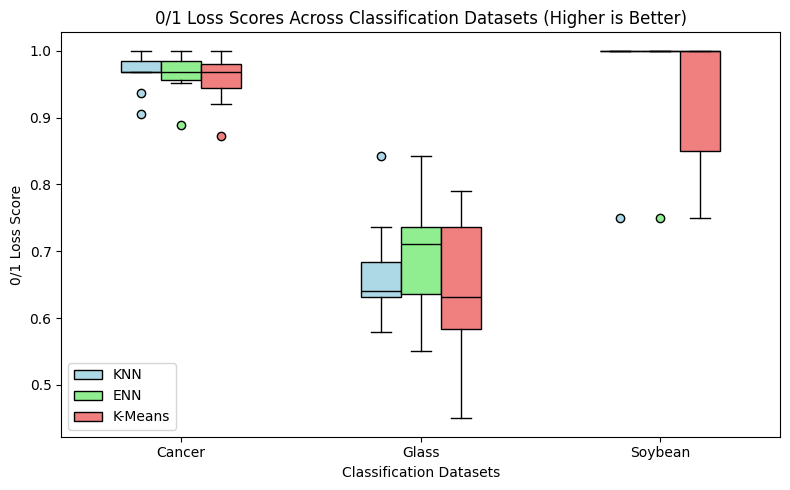

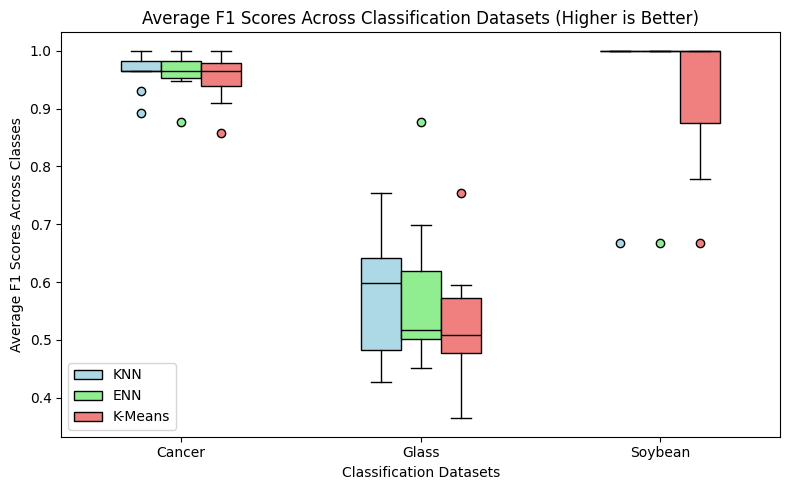

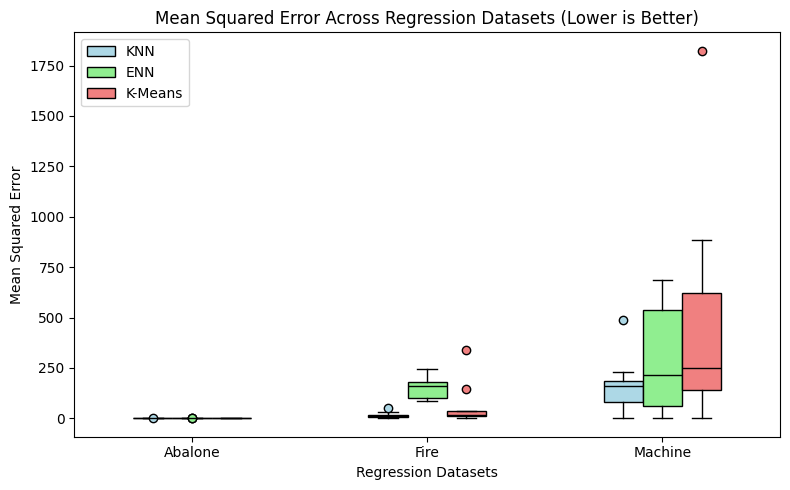

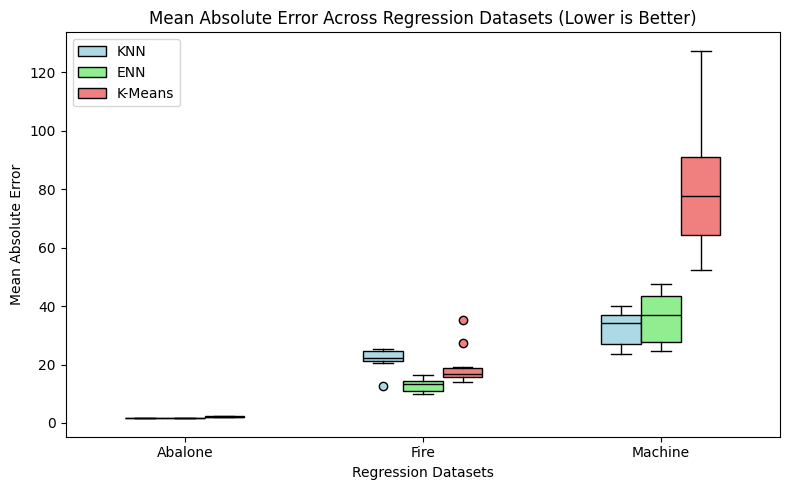

In [5]:
def make_plots_2(arrays, classification_names, regression_names, figure_size, rotation_val):
    '''
    This function creates boxplots for the metrics for classification and regression
    models across three datasets.

    Parameters:
    arrays (list of np.ndarray): List of 18 numpy arrays (each 10x2). First 9 are classification (0/1 Loss, F1),
                                 second 9 are regression (MSE, MAE).
    classification_names (list of str): List of dataset names for classification (length should be 3).
    regression_names (list of str): List of dataset names for regression (length should be 3).
    figure_size (tuple): Size of the figure.
    rotation_val (int): Rotation angle for x-axis labels.
    '''
    if len(arrays) != 18:
        raise ValueError("Expected a list of 18 numpy arrays.")

    # Split the arrays into classification and regression
    classification_arrays = arrays[:9]
    regression_arrays = arrays[9:]

    # Extract metrics for classification
    loss_data = [classification_arrays[i][:, 0] for i in range(len(classification_arrays))]
    f1_data = [classification_arrays[i][:, 1] for i in range(len(classification_arrays))]

    # Extract metrics for regression
    mse_data = [regression_arrays[i][:, 0] for i in range(len(regression_arrays))]
    mae_data = [regression_arrays[i][:, 1] for i in range(len(regression_arrays))]

    num_models = 3  # KNN, ENN, K-Means

    # Positions for boxplots - 3 models per dataset
    def calculate_positions(num_datasets, num_models, spacing, width):
        positions = []
        for i in range(num_datasets):
            base_position = i * spacing * num_models
            positions.extend([base_position, base_position + width, base_position + 2 * width])
        return positions

    width = 0.25
    spacing = .5

    positions_classification = calculate_positions(len(classification_names), num_models, spacing, width)
    positions_regression = calculate_positions(len(regression_names), num_models, spacing, width)

    # Define colors for the models
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    model_names = ['KNN', 'ENN', 'K-Means']

    # Plotting 0/1 Loss Scores (Classification)
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([loss_data[j] for j in range(i, len(loss_data), num_models)],
                    positions=[positions_classification[j] for j in range(i, len(positions_classification), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])

    plt.xticks([i * spacing * num_models + width for i in range(len(classification_names))], classification_names, rotation=rotation_val)
    plt.xlabel('Classification Datasets')
    plt.ylabel('0/1 Loss Score')
    plt.title('0/1 Loss Scores Across Classification Datasets (Higher is Better)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plotting F1 Scores (Classification)
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([f1_data[j] for j in range(i, len(f1_data), num_models)],
                    positions=[positions_classification[j] for j in range(i, len(positions_classification), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])

    plt.xticks([i * spacing * num_models + width for i in range(len(classification_names))], classification_names, rotation=rotation_val)
    plt.xlabel('Classification Datasets')
    plt.ylabel('Average F1 Scores Across Classes')
    plt.title('Average F1 Scores Across Classification Datasets (Higher is Better)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plotting Mean Squared Error (Regression)
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([mse_data[j] for j in range(i, len(mse_data), num_models)],
                    positions=[positions_regression[j] for j in range(i, len(positions_regression), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])

    plt.xticks([i * spacing * num_models + width for i in range(len(regression_names))], regression_names, rotation=rotation_val)
    plt.xlabel('Regression Datasets')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error Across Regression Datasets (Lower is Better)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plotting Mean Absolute Error (Regression)
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([mae_data[j] for j in range(i, len(mae_data), num_models)],
                    positions=[positions_regression[j] for j in range(i, len(positions_regression), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])

    plt.xticks([i * spacing * num_models + width for i in range(len(regression_names))], regression_names, rotation=rotation_val)
    plt.xlabel('Regression Datasets')
    plt.ylabel('Mean Absolute Error')
    plt.title('Mean Absolute Error Across Regression Datasets (Lower is Better)')
    plt.legend()
    plt.tight_layout()
    plt.show()
def load_arrays_from_csv(filename):
    """
    Load 18 numpy arrays (each 10x2) from a CSV file.
    
    Parameters:
    filename (str): Name of the CSV file to load the arrays from.
    
    Returns:
    list of np.ndarray: List of 18 numpy arrays extracted from the CSV file.
    """
    arrays = []
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        current_array = []
        
        for row in reader:
            # Check for metadata line or empty line
            if len(row) == 0:
                continue
            elif "Array" in row[0]:
                if current_array:
                    arrays.append(np.array(current_array, dtype=float))
                    current_array = []
            else:
                current_array.append([float(val) for val in row])
        
        # Add the last array if present
        if current_array:
            arrays.append(np.array(current_array, dtype=float))
    
    if len(arrays) != 18:
        raise ValueError("Expected to extract 18 arrays, but found a different number.")
    
    return arrays
def make_plots(arrays, dataset_names, figure_size, rotation_val):

    '''
    This function creates boxplots for the F1 scores and 0/1 loss metrics
    for three different models across three datasets.
    
    Parameters:
    arrays (list of np.ndarray): List of 9 numpy arrays (each 10x2).
    dataset_names (list of str): List of dataset names (length should be 3).
    figure_size (tuple): Size of the figure.
    rotation_val (int): Rotation angle for x-axis labels.
    '''
    if len(arrays) != 9:
        raise ValueError("Expected a list of 9 numpy arrays.")

    # Extract loss and F1 score data
    f1_data = [arrays[i][:, 1] for i in range(len(arrays))]
    loss_data = [arrays[i][:, 0] for i in range(len(arrays))]

    num_datasets = len(dataset_names)
    num_models = 3  # KNN, ENN, K-Means

    # Positions for boxplots - 3 models per dataset
    positions = []
    width = 0.25
    spacing = 1.0

    for i in range(num_datasets):
        base_position = i * spacing * num_models
        positions.extend([base_position, base_position + width, base_position + 2 * width])

    # Define colors for the models
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    model_names = ['KNN', 'ENN', 'K-Means']

    # Plotting F1 Scores
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([f1_data[j] for j in range(i, len(f1_data), num_models)],
                    positions=[positions[j] for j in range(i, len(positions), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])

    # Add labels at dataset positions
    plt.xticks([i * spacing * num_models + width for i in range(num_datasets)], dataset_names, rotation=rotation_val)
    plt.xlabel('Datasets')
    plt.ylabel('Average F1 Scores Across Classes')
    plt.title('Average F1 Scores Across Datasets (Higher is Better)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plotting 0/1 Loss Scores
    plt.figure(figsize=figure_size)
    for i in range(num_models):
        plt.boxplot([loss_data[j] for j in range(i, len(loss_data), num_models)],
                    positions=[positions[j] for j in range(i, len(positions), num_models)],
                    widths=width, patch_artist=True, boxprops=dict(facecolor=colors[i]),
                    medianprops=dict(color='black'), whiskerprops=dict(color='black'),
                    capprops=dict(color='black'), flierprops=dict(markerfacecolor=colors[i], marker='o'),
                    label=model_names[i])

    # Add labels at dataset positions
    plt.xticks([i * spacing * num_models + width for i in range(num_datasets)], dataset_names, rotation=rotation_val)
    plt.xlabel('Datasets')
    plt.ylabel('0/1 Loss Score')
    plt.title('0/1 Loss Scores Across Datasets (Lower is Better)')
    plt.legend()
    plt.tight_layout()
    plt.show()

loaded_arrays = load_arrays_from_csv('normalized_data.csv')
classification_arrays = loaded_arrays[:9]
regression_arrays = loaded_arrays[9:]
classification_dataset_names = ['Cancer', 'Glass', 'Soybean']
regression_dataset_names = ['Abalone', 'Fire', 'Machine']


#make_plots(classification_arrays, classification_dataset_names, (10, 6), 45)
#make_plots(regression_arrays, regression_dataset_names, (10, 6), 45)
make_plots_2(loaded_arrays, classification_dataset_names, regression_dataset_names, (8, 5), 0)
